# Project 1
by Jiangyong Huang on Sep 18, 2022

In [1]:
# import all the packages and initialize
import os
import torch
import numpy as np
import seaborn as sns
import skimage.io as skio
from skimage.draw import line_aa
from scipy import stats
from torch.nn.functional import interpolate
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
img_dir = 'data'

#### Problem 1

In [2]:
# initialization
# set A
nat_imgs = []
for fname in os.listdir(img_dir):
    if 'natural' in fname:
        img = skio.imread(os.path.join(img_dir, fname), as_gray=True)
        img = (img*32-0.5).astype(int)
        nat_imgs.append(img)

# set B
non_nat_img = skio.imread(os.path.join(img_dir, 'non_nat_img.jpg'), as_gray=True)
non_nat_img = (non_nat_img*32-0.5).astype(int)

# set C
syn_img = np.random.randint(low=0, high=32, size=(64, 64))

# horizontal gradient
def compute_grad(img: np.array) -> np.array:
    return img[:, 1:] - img[:, :-1]

1. Plot histogram of $H(z)$ and $\log{H(z)}$.

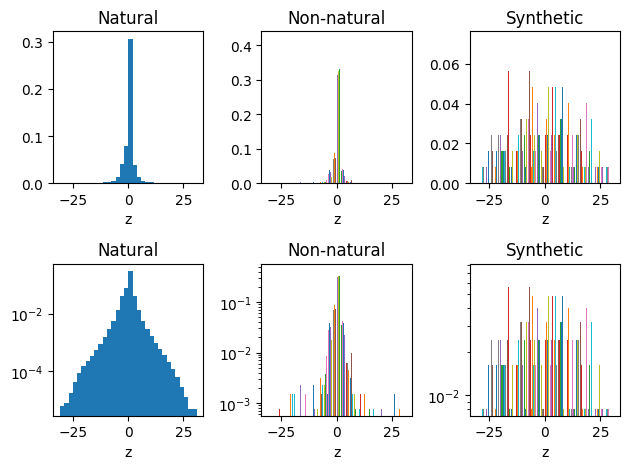

In [3]:
def vis_hist(nat_imgs, non_nat_img, syn_img, show_hist=True):
    z_A = np.concatenate([compute_grad(img).flatten() for img in nat_imgs])   # aggregate
    z_B = compute_grad(non_nat_img)
    z_C = compute_grad(syn_img)

    # H(z)
    plt.subplot(2, 3, 1)
    plt.title('Natural')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_A, bins=32, density=True)
    else:
        h, z_range = np.histogram(z_A, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)

    plt.subplot(2, 3, 2)
    plt.title('Non-natural')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_B, bins=32, density=True)
    else:
        h, z_range = np.histogram(z_B, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)

    plt.subplot(2, 3, 3)
    plt.title('Synthetic')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_C, bins=32, density=True)
    else:
        h, z_range = np.histogram(z_C, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)

    # log H(z)
    plt.subplot(2, 3, 4)
    plt.title('Natural')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_A, bins=32, density=True, log=True)
    else:
        h, z_range = np.histogram(z_A, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)
        plt.yscale('log')

    plt.subplot(2, 3, 5)
    plt.title('Non-natural')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_B, bins=32, density=True, log=True)
    else:
        h, z_range = np.histogram(z_B, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)
        plt.yscale('log')

    plt.subplot(2, 3, 6)
    plt.title('Synthetic')
    plt.xlabel('z')
    if show_hist:
        plt.hist(z_C, bins=32, density=True, log=True)
    else:
        h, z_range = np.histogram(z_C, bins=32, density=True)
        z_range = (z_range[:-1] + z_range[1:]) / 2
        plt.plot(z_range, h)
        plt.yscale('log')

    plt.tight_layout()
    return z_A, z_B, z_C

z_A, z_B, z_C = vis_hist(nat_imgs, non_nat_img, syn_img, show_hist=True)

2. Mean and variance are trivial, here I skip the formulation. Kurtosis can be computed like below:
   $$ \text{Kurt}[X] = \textbf{E}\left[\left(\frac{X-\mu}{\sigma}\right)^4\right] $$

   So, we can approximate it by estimating the quartic of normalized $z$.

In [4]:
mean_A = np.mean(z_A)
std_A = np.std(z_A)
kurt_A = np.mean(((z_A-mean_A)/std_A)**4)

mean_B = np.mean(z_B)
std_B = np.std(z_B)
kurt_B = np.mean(((z_B-mean_B)/std_B)**4)

mean_C = np.mean(z_C)
std_C = np.std(z_C)
kurt_C = np.mean(((z_C-mean_C)/std_C)**4)

print(f'A: mean={mean_A:.5f} | std={std_A:.5f} | kurt={kurt_A:.5f}')
print(f'B: mean={mean_B:.5f} | std={std_B:.5f} | kurt={kurt_B:.5f}')
print(f'C: mean={mean_C:.5f} | std={std_C:.5f} | kurt={kurt_C:.5f}')

A: mean=-0.00077 | std=2.60724 | kurt=18.82920
B: mean=0.00371 | std=2.59016 | kurt=49.02500
C: mean=-0.01438 | std=13.11780 | kurt=2.36077


3. Leverage `scipy.stats` to fit data and plot PDF. The estimated $\gamma$ is shown in the output of code cell. Note that there exists a minus between the definition in this problem and in `scipy.stats.gennorm`.

gamma_A: -0.06923 | gamma_B: -0.07156 | gamma_C: -3.38365


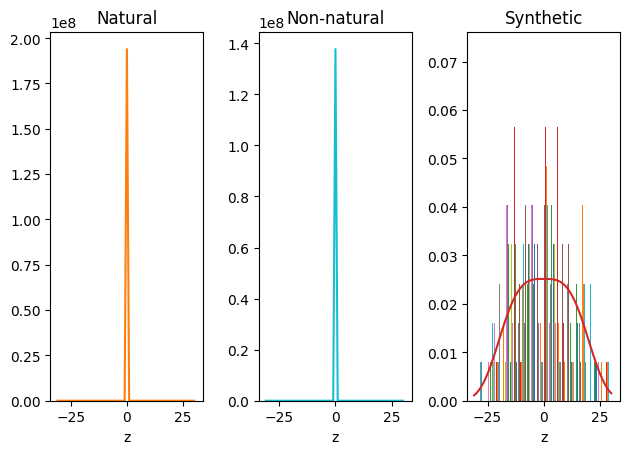

In [5]:
gamma_A, _, sigma_A = stats.gennorm.fit(z_A.flatten(), floc=0)
gamma_B, _, sigma_B = stats.gennorm.fit(z_B.flatten(), floc=0)
gamma_C, _, sigma_C = stats.gennorm.fit(z_C.flatten(), floc=0)

# plot histogram and PDF
z_range = np.arange(-31, 31, 1)

plt.subplot(1, 3, 1)
plt.title('Natural')
plt.xlabel('z')
plt.hist(z_A, bins=32, density=True)
plt.plot(z_range, stats.gennorm.pdf(z_range, beta=gamma_A, loc=0, scale=sigma_A))

plt.subplot(1, 3, 2)
plt.title('Non-natural')
plt.xlabel('z')
plt.hist(z_B, bins=32, density=True)
plt.plot(z_range, stats.gennorm.pdf(z_range, beta=gamma_B, loc=0, scale=sigma_B))

plt.subplot(1, 3, 3)
plt.title('Synthetic')
plt.xlabel('z')
plt.hist(z_C, bins=32, density=True)
plt.plot(z_range, stats.gennorm.pdf(z_range, beta=gamma_C, loc=0, scale=sigma_C))

plt.tight_layout()
print(f'gamma_A: {-gamma_A:.5f} | gamma_B: {-gamma_B:.5f} | gamma_C: {-gamma_C:.5f}')

4. Gaussian distribution and histogram, both natural scale and log scale. Note that natural images show significant kurtosis in the bottom-left figure, particularly compared with Gaussian distribution.

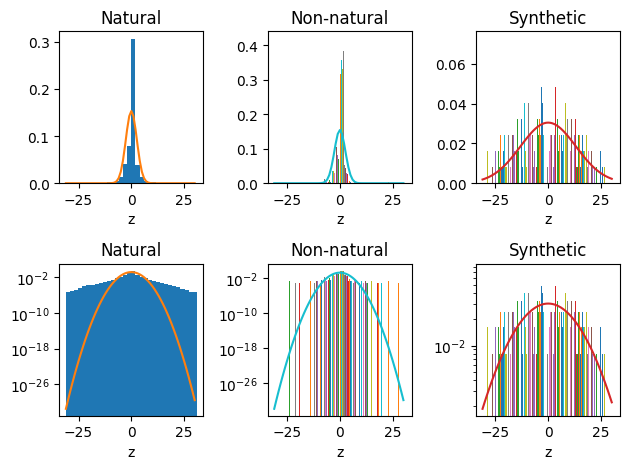

In [6]:
# H(z)
plt.subplot(2, 3, 1)
plt.title('Natural')
plt.xlabel('z')
plt.hist(z_A, bins=32, density=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_A, scale=std_A))

plt.subplot(2, 3, 2)
plt.title('Non-natural')
plt.xlabel('z')
plt.hist(z_B, bins=32, density=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_B, scale=std_B))

plt.subplot(2, 3, 3)
plt.title('Synthetic')
plt.xlabel('z')
plt.hist(z_C, bins=32, density=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_C, scale=std_C))

# log H(z)
plt.subplot(2, 3, 4)
plt.title('Natural')
plt.xlabel('z')
plt.hist(z_A, bins=32, density=True, log=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_A, scale=std_A))
plt.yscale('log')

plt.subplot(2, 3, 5)
plt.title('Non-natural')
plt.xlabel('z')
plt.hist(z_B, bins=32, density=True, log=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_B, scale=std_B))
plt.yscale('log')

plt.subplot(2, 3, 6)
plt.title('Synthetic')
plt.xlabel('z')
plt.hist(z_C, bins=32, density=True, log=True)
plt.plot(z_range, stats.norm.pdf(z_range, loc=mean_C, scale=std_C))
plt.yscale('log')

plt.tight_layout()

5. Repeat sub-sampling twice. Following are the results. We can see that natural images show almost the same distribution when sub-sampling, both natural scale and log scale. While non-natural image shows small gaps between different scales in log scale. In contrast, synthetic image shows obvious discrepancy. The results demonstrate the scale-invariance of natural images.

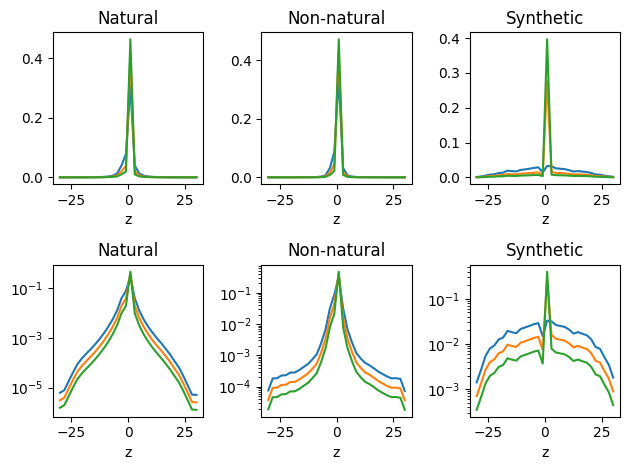

In [7]:
# torch.nn.functional.interpolate requires shapes like [B, C, H, W]
# original scale
_ = vis_hist(nat_imgs, non_nat_img, syn_img, show_hist=False)

# downsample = 2
nat_imgs_down2 = [interpolate(torch.from_numpy(img)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int) for img in nat_imgs]
non_nat_img_down2 = interpolate(torch.from_numpy(non_nat_img)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int)
syn_img_down2 = interpolate(torch.from_numpy(syn_img)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int)
_ = vis_hist(nat_imgs_down2, non_nat_img_down2, syn_img_down2, show_hist=False)

# downsample = 4
nat_imgs_down4 = [interpolate(torch.from_numpy(img)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int) for img in nat_imgs_down2]
non_nat_img_down4 = interpolate(torch.from_numpy(non_nat_img_down2)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int)
syn_img_down4 = interpolate(torch.from_numpy(syn_img_down2)[None, None, :, :].float(), scale_factor=2)[0, 0].numpy().astype(int)
_ = vis_hist(nat_imgs_down4, non_nat_img_down4, syn_img_down4, show_hist=False)

#### Problem 2

1. There is no significant formulation other than Fourier Transform, which is shown below:
   $$ \hat{I}(\xi,\eta) = \sum\limits_{(x,y)\in D_1 \times D_2} I(x,y) e^{-i2\pi(\frac{x\xi}{W}+\frac{y\eta}{H})} $$

   And our goal is to verify the inverse power law, which can be formulated as follows:
   $$ \log{A(f)} = C - \log{f}, f=\sqrt{\xi^2+\eta^2}, A(f)=|\hat{I}(\xi,\eta)|^2 $$

   In my implementation, I discretize the range of $\log{f}$ and average the amplitute in each bin, in order to present better curves. In addition to the final $\log{A}-\log{f}$ curve revealing the inverse power law, I also visualize the frequency spectrum of each natural image. My codes are as follows:

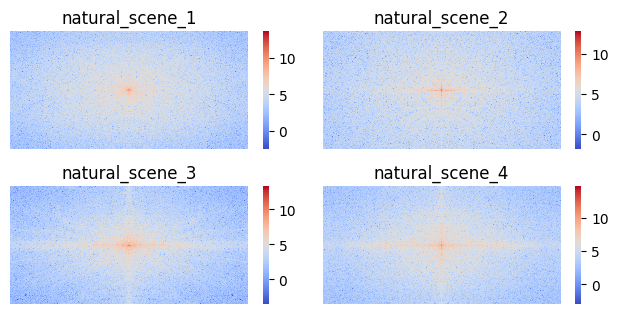

In [8]:
def verify_inverse_power_law(img):
    # return a tuple: (shifted log frequency spectrum, array to visualize curves)
    H, W = img.shape[:2]
    c_h = np.floor((H-1)/2).astype(int)   # center coordinate
    c_w = np.floor((W-1)/2).astype(int)   # center coordinate

    FT_raw = np.abs(np.fft.fft2(img))   # get norm of complex value
    A = np.zeros((2*c_h+1, 2*c_w+1))
    A[c_h::-1, c_w::-1] = FT_raw[:c_h+1, :c_w+1]   # up-left
    A[c_h::-1, c_w:] = FT_raw[:c_h+1, :c_w+1]   # up-right
    A[c_h:, c_w::-1] = FT_raw[:c_h+1, :c_w+1]   # bottom-left
    A[c_h:, c_w:] = FT_raw[:c_h+1, :c_w+1]   # bottom-right
    A = np.log(A)

    r = np.indices((c_h+1, c_w+1)).transpose(1, 2, 0)
    r = np.linalg.norm(r, axis=-1, keepdims=False)
    r = np.log10(r + 1e-6)
    f_max = r.max()
    f_list = np.arange(0, f_max, 0.03)
    a_list = []
    f_num = len(f_list)
    for i in range(f_num):
        idx_mask = np.logical_and(r>f_list[i], r<=(f_list[i+1] if i < f_num-1 else f_max))
        if np.any(idx_mask):
            a_list.append(np.array([f_list[i], np.mean(A[c_h:, c_w:][idx_mask])]))
    
    return A, np.stack(a_list, axis=0)

def solve_p2(img_dir):
    data_to_show = {}
    for fname in os.listdir(img_dir):
        if 'natural' in fname:
            img = skio.imread(os.path.join(img_dir, fname), as_gray=True)
            data_to_show.update({
                os.path.splitext(fname)[0]: verify_inverse_power_law(img)
            })
    
    num_img = len(data_to_show)
    layout_side = np.ceil(np.sqrt(num_img)).astype(int)
    maps = {}
    curves = {}
    i = 1
    for k, v in data_to_show.items():
        A_map, A_list = v
        plt.subplot(layout_side+1, layout_side, i)
        plt.title(k)
        sns.heatmap(A_map, cmap='coolwarm', xticklabels=False, yticklabels=False)
        maps.update({k: np.exp(A_map)})   # back to natural range
        curves.update({k: A_list})
        i += 1
    
    plt.tight_layout()
    return maps, curves

maps, curves = solve_p2(img_dir)

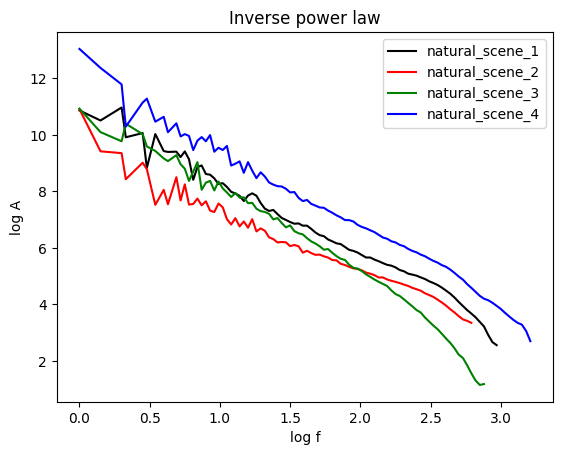

In [9]:
# visualize the curves to verify inverse power law
colorlist = ['black', 'red', 'green', 'blue']
plt.figure()
for i, k in enumerate(curves.keys()):
    plt.plot(curves[k][:, 0], curves[k][:, 1], color=colorlist[i], label=k)
plt.title('Inverse power law')
plt.xlabel('log f')
plt.ylabel('log A')
plt.legend()
plt.show()

2. Given the conclusion that $A \propto \frac{1}{f}$, we can analytically prove the integral $S(f_0)$ is a constant. The derivation is as follows:
   $$ \begin{aligned}
   S(f_0) &= \iint\limits_{f_0<f<2f_0} A^2(f) d\xi d\eta \\
          &= \iint\limits_{f_0<f<2f_0} A^2(f) f df d\theta \\
          &= 2\pi \int_{f_0}^{2f_0} A^2(f) f df \\
          &= 2\pi \int_{f_0}^{2f_0} \frac{1}{f^2} f df \\
          &= 2\pi \int_{f_0}^{2f_0} \frac{df}{f} \\
          &= 2\pi \ln{\frac{2f_0}{f_0}} \\
          &= C, \forall f_0
   \end{aligned} $$

   In my implementation, I reuse the frequency spectrums to calculate summation in each ring. Actually, such operations are already accomplished in previous codes where I average the amplitude in rings. Differently, here we will accumulate the amplitude square. Note that the spectrum is identical in four quadrants, so accumulating in one is equivalent. The results show firm power invariance w.r.t. bandwidth, i.e. the point where frequency starts and ends at twice value, regardless of the noise at low frequecy in natural image 4. The mismatch may be explained by a lack of samples in low-frequency area, making the integrated value not so robust.

100%|██████████| 40/40 [00:01<00:00, 37.74it/s]


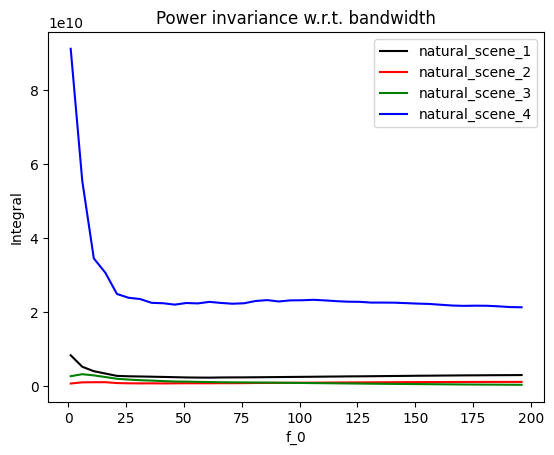

In [10]:
def power_integral(A_map, f0):
    A_map = A_map ** 2   # amplitude to power
    c_h, c_w = A_map.shape[:2]
    c_h = (c_h - 1) // 2
    c_w = (c_w - 1) // 2

    r = np.indices((c_h+1, c_w+1)).transpose(1, 2, 0)
    r = np.linalg.norm(r, axis=-1, keepdims=False)
    idx_mask = np.logical_and(r>f0, r<=2*f0)
    if np.any(idx_mask):
        return np.sum(A_map[c_h:, c_w:][idx_mask])
    else:
        raise ValueError('improper value for f_0')

f0_list = np.arange(1, 200, 5)
plt.figure()
plt.title('Power invariance w.r.t. bandwidth')
plt.xlabel('f_0')
plt.ylabel('Integral')
plt.yticks(rotation=0)
for i, k in enumerate(maps.keys()):
    inte = []
    for f0 in tqdm(f0_list):
        inte.append(power_integral(maps[k], f0))
    plt.plot(f0_list, inte, color=colorlist[i], label=k)
plt.legend()
plt.show()

#### Problem 3

1. Uniformly sample continuous values of $(x_i,y_i) \in [0, 1023]$, $\theta_i \in [0, \pi]$. Given that $p(r) \propto \frac{1}{r^3}$, we can infer that $r$ has a lower bound, which ensures the its CDF bounded. More specifically, we can utilize the bounded CDF to sample $r$. The intuition is that we can construct the correspondence between $r$ and $P(r\gt \alpha)$ for a random variable $\alpha$ which is uniformly sampled in $[0, 1]$. This can be formulated as follows:
   $$ \int_{r_\alpha}^{+\infty} p(r) dr = \alpha \Rightarrow \frac{C}{2}r_\alpha^{-2} = \alpha \Rightarrow r_\alpha = \frac{C}{\sqrt{2\alpha}}, \alpha \in [0, 1] $$

   The formulation above incorporates the assumption that $p(r) = \frac{C}{r^3}$. To accomodate more valid line segments, I make $C$ a little larger. For resolution at 1024, C is assigned as 8. And $C$ decreases linearly with the resolution scaling down, which means $C=4$ at 512x512 and $C=2$ at 256x256. Considering the density of lines, the total number of lines $N$ at 1024x1024 is set to 5000, if we control the expectation of lines located in each unit area to be a constant, we can infer that the total number of lines $N$ decreases quadratically with the resolution scaling down, which means $N=1250$ at 512x512 and $N=313$ at 256x256.

2. The two down-sample versions are included together in the following codes as well as visualization results.

100%|██████████| 313/313 [00:00<00:00, 77995.32it/s]


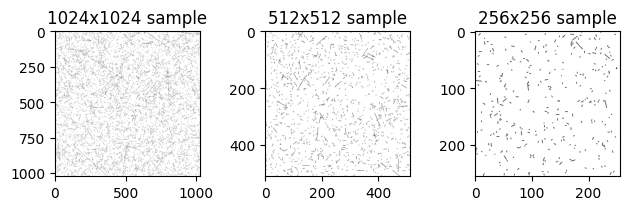

In [11]:
def GenLength(img_reso, size):
    alpha = np.random.random(size=size)
    if img_reso == 1024:
        return 8 / np.sqrt(2*alpha)
    elif img_reso == 512:
        return 4 / np.sqrt(2*alpha)
    elif img_reso == 256:
        return 2 / np.sqrt(2*alpha)
    else:
        raise ValueError

def GenImg(N=5000, reso=1024):
    # white background, black line segments
    coordinates = np.random.uniform(0, reso-1, size=(N, 2))
    orient = np.random.uniform(0, np.pi, size=N)
    length = GenLength(img_reso=reso, size=N)
    img = np.ones((reso, reso))

    # draw lines
    for i in trange(N):
        x1 = int(coordinates[i, 0] - length[i]/2*np.cos(orient[i]))
        y1 = int(coordinates[i, 1] - length[i]/2*np.sin(orient[i]))
        x2 = int(coordinates[i, 0] + length[i]/2*np.cos(orient[i]))
        y2 = int(coordinates[i, 1] + length[i]/2*np.sin(orient[i]))
        rr, cc, val = line_aa(r0=y1, c0=x1, r1=y2, c1=x2)
        
        # truncation
        trun_mask_r = np.logical_and(rr>=0, rr<reso)
        trun_mask_c = np.logical_and(cc>=0, cc<reso)
        trun_mask = np.logical_and(trun_mask_r, trun_mask_c)

        rr = rr[trun_mask]
        cc = cc[trun_mask]
        val = 1- val[trun_mask]   # black line segments

        img[rr, cc] = val
    
    return img

img_1024 = GenImg(N=5000, reso=1024)
img_512 = GenImg(N=1250, reso=512)
img_256 = GenImg(N=313, reso=256)

plt.subplot(1, 3, 1)
plt.title('1024x1024 sample')
plt.imshow(img_1024, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('512x512 sample')
plt.imshow(img_512, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('256x256 sample')
plt.imshow(img_256, cmap='gray')

plt.tight_layout()

3. Crop 2 image patches of size 128×128 pixels randomly from each of the three images generated above. The results are organized in 3 rows and 2 columns structure, with each row representing a image scale (1024/512/256).

   In comparison, the image at lower resolution shows sparser appearance. However, due to the control of density, we find they look similar when after cropping out regions with the same area. From this perspective, images show scale-invariance, and it is hard to tell which scale one crop is taken from when only presented with such a view. Despite this trait shared across scales, there is discrepancy concerning length statistics of line segments. This may be a subtle clue to distinguish crops from different scales, since crops from higher resolution usually include longer line segments, which can be observed when we compare 1024 versus 256.

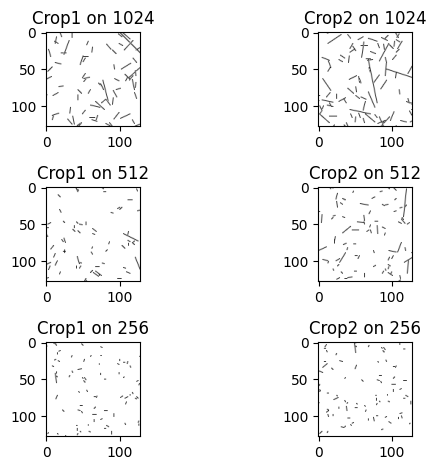

In [12]:
# crop on 1024
for i in range(1, 3):
    r_start, c_start = np.random.randint(0, 1024-128+1, size=2)
    plt.subplot(3, 2, i)
    plt.title(f'Crop{i} on 1024')
    plt.imshow(img_1024[r_start: r_start+128, c_start: c_start+128], cmap='gray')

# crop on 512
for i in range(3, 5):
    r_start, c_start = np.random.randint(0, 512-128+1, size=2)
    plt.subplot(3, 2, i)
    plt.title(f'Crop{i-2} on 512')
    plt.imshow(img_512[r_start: r_start+128, c_start: c_start+128], cmap='gray')

# crop on 256
for i in range(5, 7):
    r_start, c_start = np.random.randint(0, 256-128+1, size=2)
    plt.subplot(3, 2, i)
    plt.title(f'Crop{i-4} on 256')
    plt.imshow(img_256[r_start: r_start+128, c_start: c_start+128], cmap='gray')

plt.tight_layout()